## Calculate number of heat waves and cold waves per decade (based on a user-defined threshold) for each climate division; plot these as graphs on a map

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import os

from scipy import stats
import pymannkendall as mk

from metpy.plots import USCOUNTIES
from matplotlib.offsetbox import AnchoredText


### specify the definition of a heat wave or cold wave. In the Climate Change in Colorado report, a return period of 1 year and a duration of 4 days was used, but these can be changed here by the user

In [2]:
return_period = 1  ### return period to analyze: number of times per year on average
ndays = 4 ### number of days to define a heat wave

### read in the file with definitions of the climate divisions

In [3]:
mask_in = xr.open_dataset("data/clusters_tavg_prcp_sum_post1950_11_pub.nc")['clusters_tavg_prcp_sum']

climdiv_abbrevs=["d1","d2","d3","d4","d5","d6","d7","d8","d9","d10","d11"]
climdivs=[1,2,3,4,5,6,7,8,9,10,11]
climdiv_names = ["Pikes Peak","Southeast","Northern Front Range","Northeast","South Park",
             "San Luis Valley & Sangre de Cristos","Southwest","Mesas and Valleys","Northwest",
             "Northern Mountains","Central Mountains"]


### define a function for plotting the insets, based on this answer: https://stackoverflow.com/a/45285824


In [4]:
def xy_from_longlat(lon, lat):
    """convert long-lat (degrees) to grid values""" 
    return crs.transform_point(lon, lat, ccrs.PlateCarree())

In [5]:
### plot settings
plt.rcParams['savefig.dpi'] = 255
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'


### now construct the map, do the calculations, and plot the graphs (see comments embedded below)

1
captured 30 heatwaves
significant!
2
captured 30 heatwaves
3
captured 30 heatwaves
significant!
4
captured 30 heatwaves
5
captured 30 heatwaves
significant!
6
captured 30 heatwaves
significant!
7
captured 30 heatwaves
significant!
8
captured 30 heatwaves
significant!
9
captured 30 heatwaves
significant!
10
captured 30 heatwaves
significant!
11
captured 30 heatwaves


/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


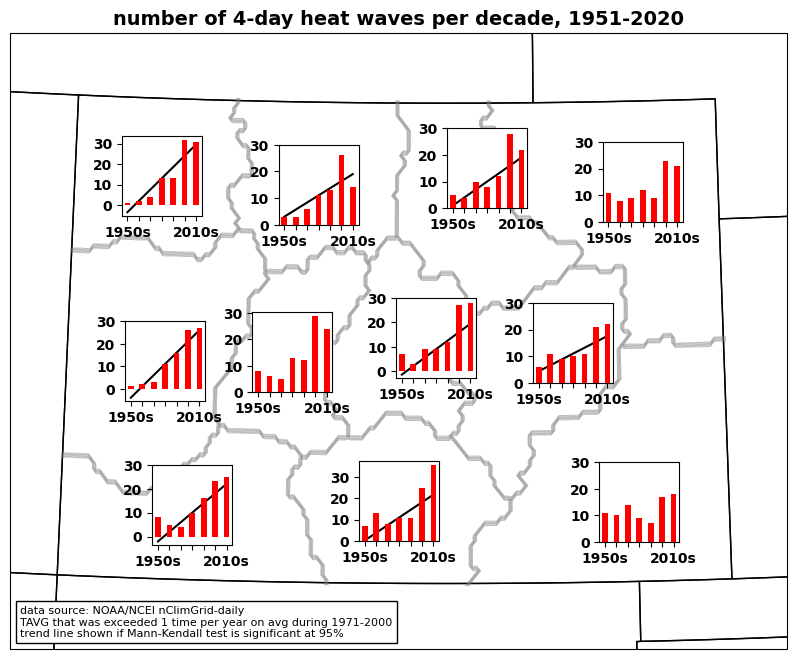

In [6]:
### set up map of divisions
crs = ccrs.LambertConformal(central_longitude=-105.0, central_latitude=40.)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=crs)

## Colorado versions
lonmin=-109.5
lonmax=-101.5
latmin=36.4
latmax=41.5
#lonmin=-109.046667
#lonmax=-102.046667
#latmin=37.0
#latmax=41.0

ax.set_extent([lonmin,lonmax,latmin,latmax])
#ax.add_feature(cfeature.LAND)
#ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

## trend
#cf1 = ax.contourf(trend_mapped.lon, trend_mapped.lat, trend_mapped, 
#                  np.arange(-5,5.25,0.25), extend='both',
#                  cmap="RdBu_r",
#                  transform=ccrs.PlateCarree())

## also lightly outline the divisions -- kind of hacky masking to make the contours all the same thickness
for div in range(1,12):
    mask_temp = xr.where(mask_in==div,1,0)
    ax.contour(mask_temp.lon, mask_temp.lat, mask_temp,
              #levels=[0],
               colors='gray',
               linewidths=0.15,
              transform=ccrs.PlateCarree())

### add an inset graph to each division
for div in range(0,11):
    climdiv_abbrev=climdiv_abbrevs[div]
    climdiv = climdivs[div]
    climdiv_name=climdiv_names[div]
    
    print(climdiv)
    
    div_title = climdiv_name+" division"
    data = pd.read_csv("data/tavg_daily_"+str(climdiv_abbrev)+".csv")
    
    cent_lon = mask_in.where(mask_in==div+1,drop=True).lon.mean()
    cent_lat = mask_in.where(mask_in==div+1,drop=True).lat.mean()
    
    data.time = pd.to_datetime(data.time)
    data.set_index('time', inplace=True)

    ### convert to F
    data['tavg'] = 1.8*data['tavg']+32.
    
    ### calculate n-day periods
    tavg_nday = data.rolling(ndays).mean().dropna().reset_index()

    ### add column for start date too
    tavg_nday['start'] = tavg_nday.time - pd.Timedelta(days=ndays-1)
    tavg_nday['end'] = tavg_nday['time']
    tavg_nday.set_index('time', inplace=True)
    
    ### find N-day heat waves that occur M times on average during 1971-2000 (i.e., the top M*30 cases)

    ### first, we'll look for a larger number of cases, before removing overlaps
    first_cut = tavg_nday['1971-01-01':'2000-12-31'].sort_values(by='tavg',ascending=False).head(400)

    ### remove overlaps following this answer: https://stackoverflow.com/a/68630386
    intervals = pd.IntervalIndex.from_arrays(first_cut.start, 
                                             first_cut.end, 
                                             closed='both')

    index = np.arange(intervals.size)
    keep = [] # indices of `df` to be retained   

    # get rid of the indices where the intervals overlap
    for interval in intervals:
        keep.append(index[0])
        checks = intervals[index].overlaps(intervals[index[0]])
        if checks.any():
            index = index[~checks]
        else:
            break
        if index.size == 0:
            break

    heatwaves_7100 = first_cut.iloc[keep].head(int(return_period*30))
    print("captured "+str(heatwaves_7100.shape[0])+" heatwaves")

    thresh_tavg_7100_high = heatwaves_7100['tavg'].tail(1).values[[0]][0]

    ### now repeat for the whole dataset, finding all heatwaves with tavg greater than the identified value
    first_cut_all = tavg_nday[tavg_nday.tavg >= thresh_tavg_7100_high].sort_values(by='tavg',ascending=False)
    first_cut_all

    ### remove overlaps following this answer: https://stackoverflow.com/a/68630386
    intervals = pd.IntervalIndex.from_arrays(first_cut_all.start, 
                                             first_cut_all.end, 
                                             closed='both')

    index = np.arange(intervals.size)
    keep = [] # indices of `df` to be retained   

    # get rid of the indices where the intervals overlap
    for interval in intervals:
        keep.append(index[0])
        checks = intervals[index].overlaps(intervals[index[0]])
        if checks.any():
            index = index[~checks]
        else:
            break
        if index.size == 0:
            break

    heatwaves_all = first_cut_all.iloc[keep]

    ### resample to years and decades
    heatwaves_year = heatwaves_all.groupby(heatwaves_all.index.year).count().reindex(range(1951,2023), fill_value=0)

    year_reind = heatwaves_year.copy()
    year_reind.index = pd.to_datetime(year_reind.index, format='%Y')
    heatwaves_decade = year_reind[:'2020-12-31'].resample('10AS').sum()
    heatwaves_decade['year'] = heatwaves_decade.index.year
    heatwaves_decade = heatwaves_decade.reset_index().set_index('year')

    ### do Mann-Kendall test, which also calculates Theil-Sen slope
    res = mk.original_test(heatwaves_decade['tavg'])
    X = heatwaves_decade.reset_index().index  ### index going from 0 to length of vector
    if (res.h==True) & (res.p < 0.05) & (res.slope != 0):
        sig=True
    else:
        sig=False
    
    ### add insets based on this answer: https://stackoverflow.com/a/45285824
    mapx, mapy = xy_from_longlat(cent_lon, cent_lat)
    
    if (div==1):  ## define horizontal alignment
        hor_align = "upper left"
    elif (div==0) or (div==3):
        hor_align = "lower left"
    elif (div==4):
        hor_align = "center left"
    elif (div==2):
        hor_align = "lower center"
    else:
        hor_align = "center"

   # if (div==7): 
   #     vert_align = "top"
   # else:
   #     vert_align = "center"
    
    ax_inset = inset_axes(ax, width=0.8, \
                       height=0.8, loc=hor_align, \
                       bbox_to_anchor=(mapx, mapy), \
                       bbox_transform=ax.transData, \
                       borderpad=0)   

    heatwaves_decade['tavg'].plot.bar(ax=ax_inset, color='red', xlabel='', ylabel='',zorder=10)
                #title="number of "+str(ndays)+"-day heat waves, "+div_title+" TAVG ≥ "+str(round(thresh_tavg_7100_high,1))+"°F",
                                  #xlabel='decade',ylabel='count')

    ax_inset.set_xticklabels(["1950s","","","","","","2010s"], rotation=0,
                            fontweight='bold')
    
    ### plot a trend line if significant
    if sig:
        print("significant!")
        pd.Series(res.intercept+res.slope*X,heatwaves_decade.index).plot.line(c='black', ax=ax_inset, use_index=False)
    
    ax_inset.set_yticks(range(0,40,10))
    ax_inset.set_yticklabels(ax_inset.get_yticks(), weight='bold')
    ax_inset.set_title('')

        
ax.set_title("number of "+str(ndays)+"-day heat waves per decade, 1951-2020", fontsize=14, fontweight='semibold')
#cb1 = fig.colorbar(cf1, ax=ax, orientation='horizontal', aspect=30, shrink=0.65, pad=0.01)
#cb1.set_label('trend (°F)', size='large')

# Add a text annotation 
text = AnchoredText("data source: NOAA/NCEI nClimGrid-daily\nTAVG that was exceeded "+str(return_period)+" time per year on avg during 1971-2000\ntrend line shown if Mann-Kendall test is significant at 95%",
                    loc='lower left', prop={'size': 8}, frameon=True)
ax.add_artist(text)

fig.savefig("heatwaves_map_"+str(ndays)+"days_avg_"+str(int(1/return_period))+"yr.png")

plt.show()

plt.close('all')

### repeat for cold

1
captured 30 coldwaves
Mann_Kendall_Test(trend='no trend', h=False, p=0.44752091013046913, z=-0.7595545253127499, Tau=-0.2857142857142857, s=-6.0, var_s=43.333333333333336, slope=-1.0, intercept=11.0)
2
captured 30 coldwaves
Mann_Kendall_Test(trend='no trend', h=False, p=0.5480055723613093, z=-0.6007514091861106, Tau=-0.23809523809523808, s=-5.0, var_s=44.333333333333336, slope=-1.0, intercept=11.0)
3
captured 30 coldwaves
Mann_Kendall_Test(trend='no trend', h=False, p=0.7585470626386264, z=-0.30738931174713596, Tau=-0.14285714285714285, s=-3.0, var_s=42.333333333333336, slope=-0.2, intercept=8.6)
4
captured 30 coldwaves
Mann_Kendall_Test(trend='no trend', h=False, p=0.5480055723613093, z=-0.6007514091861106, Tau=-0.23809523809523808, s=-5.0, var_s=44.333333333333336, slope=-0.75, intercept=9.25)
5
captured 30 coldwaves
Mann_Kendall_Test(trend='no trend', h=False, p=0.7585470626386264, z=-0.30738931174713596, Tau=-0.14285714285714285, s=-3.0, var_s=42.333333333333336, slope=-0.5, inte

/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


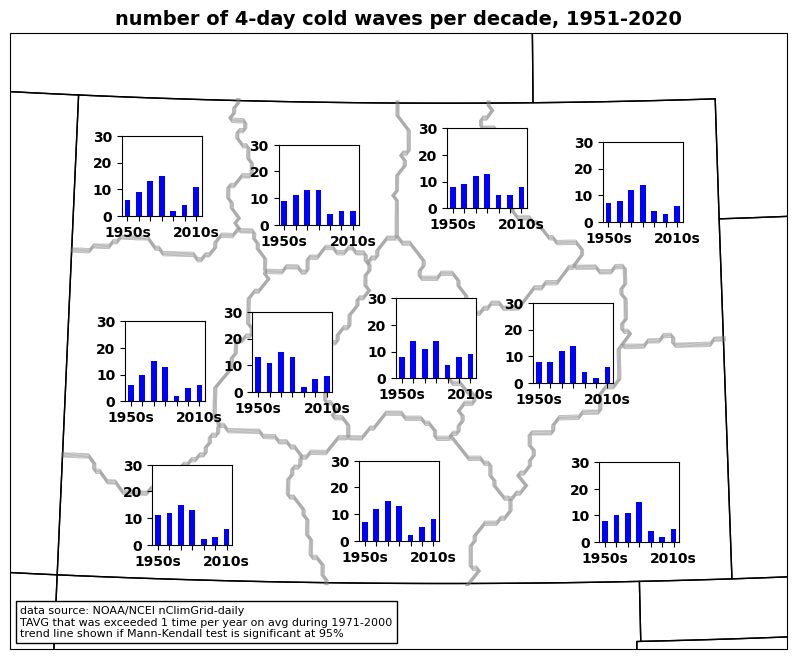

In [7]:
### set up map of divisions
crs = ccrs.LambertConformal(central_longitude=-105.0, central_latitude=40.)
#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=42.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=crs)

## Colorado versions
lonmin=-109.5
lonmax=-101.5
latmin=36.4
latmax=41.5
#lonmin=-109.046667
#lonmax=-102.046667
#latmin=37.0
#latmax=41.0

ax.set_extent([lonmin,lonmax,latmin,latmax])
#ax.add_feature(cfeature.LAND)
#ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

## trend
#cf1 = ax.contourf(trend_mapped.lon, trend_mapped.lat, trend_mapped, 
#                  np.arange(-5,5.25,0.25), extend='both',
#                  cmap="RdBu_r",
#                  transform=ccrs.PlateCarree())

## also lightly outline the divisions -- kind of hacky masking to make the contours all the same thickness
for div in range(1,12):
    mask_temp = xr.where(mask_in==div,1,0)
    ax.contour(mask_temp.lon, mask_temp.lat, mask_temp,
              #levels=[0],
               colors='gray',
               linewidths=0.15,
              transform=ccrs.PlateCarree())

### add an inset graph to each division
for div in range(0,11):
    climdiv_abbrev=climdiv_abbrevs[div]
    climdiv = climdivs[div]
    climdiv_name=climdiv_names[div]
    
    print(climdiv)
    
    div_title = climdiv_name+" division"
    data = pd.read_csv("data/tavg_daily_"+str(climdiv_abbrev)+".csv")
    
    cent_lon = mask_in.where(mask_in==div+1,drop=True).lon.mean()
    cent_lat = mask_in.where(mask_in==div+1,drop=True).lat.mean()
    
    data.time = pd.to_datetime(data.time)
    data.set_index('time', inplace=True)

    ### convert to F
    data['tavg'] = 1.8*data['tavg']+32.
    
    ### calculate n-day periods
    tavg_nday = data.rolling(ndays).mean().dropna().reset_index()

    ### add column for start date too
    tavg_nday['start'] = tavg_nday.time - pd.Timedelta(days=ndays-1)
    tavg_nday['end'] = tavg_nday['time']
    tavg_nday.set_index('time', inplace=True)
    
    ### find N-day cold waves that occur M times on average during 1971-2000 (i.e., the top M*30 cases)

    ### first, we'll look for a larger number of cases, before removing overlaps
    first_cut = tavg_nday['1971-01-01':'2000-12-31'].sort_values(by='tavg',ascending=True).head(400)

    ### remove overlaps following this answer: https://stackoverflow.com/a/68630386
    intervals = pd.IntervalIndex.from_arrays(first_cut.start, 
                                             first_cut.end, 
                                             closed='both')

    index = np.arange(intervals.size)
    keep = [] # indices of `df` to be retained   

    # get rid of the indices where the intervals overlap
    for interval in intervals:
        keep.append(index[0])
        checks = intervals[index].overlaps(intervals[index[0]])
        if checks.any():
            index = index[~checks]
        else:
            break
        if index.size == 0:
            break

    coldwaves_7100 = first_cut.iloc[keep].head(int(return_period*30))
    print("captured "+str(coldwaves_7100.shape[0])+" coldwaves")

    thresh_tavg_7100_high = coldwaves_7100['tavg'].tail(1).values[[0]][0]

    ### now repeat for the whole dataset, finding all coldwaves with tavg greater than the identified value
    first_cut_all = tavg_nday[tavg_nday.tavg <= thresh_tavg_7100_high].sort_values(by='tavg',ascending=True)
    first_cut_all

    ### remove overlaps following this answer: https://stackoverflow.com/a/68630386
    intervals = pd.IntervalIndex.from_arrays(first_cut_all.start, 
                                             first_cut_all.end, 
                                             closed='both')

    index = np.arange(intervals.size)
    keep = [] # indices of `df` to be retained   

    # get rid of the indices where the intervals overlap
    for interval in intervals:
        keep.append(index[0])
        checks = intervals[index].overlaps(intervals[index[0]])
        if checks.any():
            index = index[~checks]
        else:
            break
        if index.size == 0:
            break

    coldwaves_all = first_cut_all.iloc[keep]

    ### resample to years and decades
    coldwaves_year = coldwaves_all.groupby(coldwaves_all.index.year).count().reindex(range(1951,2023), fill_value=0)

    year_reind = coldwaves_year.copy()
    year_reind.index = pd.to_datetime(year_reind.index, format='%Y')
    coldwaves_decade = year_reind[:'2020-12-31'].resample('10AS').sum()
    coldwaves_decade['year'] = coldwaves_decade.index.year
    coldwaves_decade = coldwaves_decade.reset_index().set_index('year')

    ### do Mann-Kendall test, which also calculates Theil-Sen slope
    res = mk.original_test(coldwaves_decade['tavg'])
    X = coldwaves_decade.reset_index().index  ### index going from 0 to length of vector
    if (res.h==True) & (res.p < 0.05) & (res.slope != 0):
        sig=True
    else:
        sig=False
    print(res)
    
    ### add insets based on this answer: https://stackoverflow.com/a/45285824
    mapx, mapy = xy_from_longlat(cent_lon, cent_lat)
    
    if (div==1):  ## define horizontal alignment
        hor_align = "upper left"
    elif (div==0) or (div==3):
        hor_align = "lower left"
    elif (div==4):
        hor_align = "center left"
    elif (div==2):
        hor_align = "lower center"
    else:
        hor_align = "center"

   # if (div==7): 
   #     vert_align = "top"
   # else:
   #     vert_align = "center"
    
    ax_inset = inset_axes(ax, width=0.8, \
                       height=0.8, loc=hor_align, \
                       bbox_to_anchor=(mapx, mapy), \
                       bbox_transform=ax.transData, \
                       borderpad=0)   

    coldwaves_decade['tavg'].plot.bar(ax=ax_inset, color='blue', xlabel='', ylabel='',zorder=10)
                #title="number of "+str(ndays)+"-day cold waves, "+div_title+" TAVG ≥ "+str(round(thresh_tavg_7100_high,1))+"°F",
                                  #xlabel='decade',ylabel='count')
            
    ### plot a trend line if significant
    if sig:
        print("significant!")
        pd.Series(res.intercept+res.slope*X,coldwaves_decade.index).plot.line(c='black', ax=ax_inset, use_index=False)

    ax_inset.set_xticklabels(["1950s","","","","","","2010s"], rotation=0,
                            fontweight='bold')
    ax_inset.set_yticks(range(0,40,10))
    ax_inset.set_yticklabels(ax_inset.get_yticks(), weight='bold')
    ax_inset.set_title('')
        
ax.set_title("number of "+str(ndays)+"-day cold waves per decade, 1951-2020", fontsize=14, fontweight='semibold')
#cb1 = fig.colorbar(cf1, ax=ax, orientation='horizontal', aspect=30, shrink=0.65, pad=0.01)
#cb1.set_label('trend (°F)', size='large')

# Add a text annotation 
text = AnchoredText("data source: NOAA/NCEI nClimGrid-daily\nTAVG that was exceeded "+str(return_period)+" time per year on avg during 1971-2000\ntrend line shown if Mann-Kendall test is significant at 95%",
                    loc='lower left', prop={'size': 8}, frameon=True)
ax.add_artist(text)

fig.savefig("coldwaves_map_"+str(ndays)+"days_avg_"+str(int(1/return_period))+"yr.png",
           dpi=250,transparent=False, facecolor='white', bbox_inches='tight')

plt.show()

plt.close('all')